In [2]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
import numpy as np
from SimPEG.EM import FDEM, TDEM, mu_0
import matplotlib.pyplot as plt
import matplotlib
try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

%matplotlib inline

# Set up cylindrically symmeric mesh

In [3]:
cs, ncx, ncz, npad = 10., 15, 25, 13  # padded cyl mesh
hx = [(cs, ncx), (cs, npad, 1.3)]
hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
mesh = Mesh.CylMesh([hx, 1, hz], '00C')

# Conductivity model

In [4]:
layerz = np.r_[-200., -100.]
layer = (mesh.vectorCCz >= layerz[0]) & (mesh.vectorCCz <= layerz[1])
active = mesh.vectorCCz < 0.
sig_half = 1e-2  # Half-space conductivity
sig_air = 1e-8  # Air conductivity
sig_layer = 5e-2  # Layer conductivity
sigma = np.ones(mesh.nCz)*sig_air
sigma[active] = sig_half
sigma[layer] = sig_layer

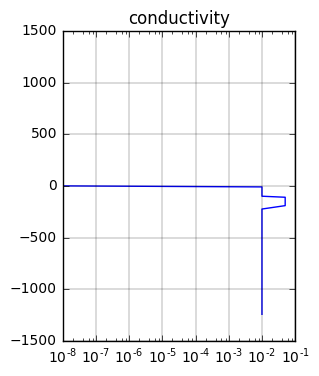

In [22]:
fig, ax = plt.subplots(1,1, figsize = (3, 4))
ax.semilogx(sigma, mesh.vectorCCz)
ax.grid(which = 'major', linestyle = '-', linewidth=0.2)
ax.set_title('conductivity')

# Mapping

In [18]:
actMap = Maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nCz)
mapping = Maps.ExpMap(mesh) * Maps.SurjectVertical1D(mesh) * actMap
mtrue = np.log(sigma[active])

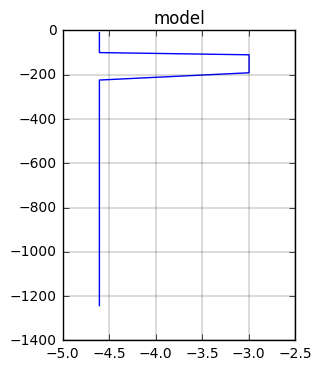

In [23]:
fig, ax = plt.subplots(1,1, figsize = (3, 4))
ax.plot(mtrue, mesh.vectorCCz[active])
ax.grid(which = 'major', linestyle = '-', linewidth=0.2)
ax.set_title('model')

# Survey

In [28]:
# TDEM survey
rxlocs = Utils.ndgrid([np.r_[50.], np.r_[0], np.r_[0.]])
srcLoc = np.r_[0., 0., 0.]
times = np.logspace(-4, np.log10(2e-3), 10)

print('min diffusion distance ', 1.28*np.sqrt(times.min()/(sig_half*mu_0)),
      'max diffusion distance ', 1.28*np.sqrt(times.max()/(sig_half*mu_0)))
rx = TDEM.Rx.Point_b(rxlocs, times, 'z')
src = TDEM.Src.MagDipole(
    [rx],
    waveform=TDEM.Src.StepOffWaveform(),
    loc=srcLoc  # same src location as FDEM problem
)

surveyTD = TDEM.Survey([src])


('min diffusion distance ', 114.18394343377736, 'max diffusion distance ', 510.64611891383385)


# Problem

In [29]:
prbTD = TDEM.Problem3D_b(mesh, sigmaMap=mapping, Solver=Solver)
prbTD.timeSteps = [(5e-5, 10), (1e-4, 10), (5e-4, 10)]
prbTD.pair(surveyTD)

std = 0.03
surveyTD.makeSyntheticData(mtrue, std)
surveyTD.std = std
surveyTD.eps = np.linalg.norm(surveyTD.dtrue)*1e-5

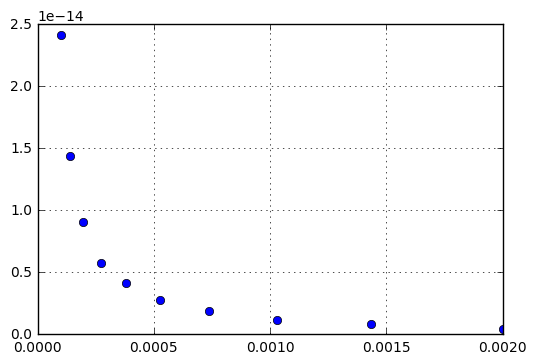

In [37]:
plt.plot(times, surveyTD.dobs, 'o')
plt.grid(which = 'both')

# set up the inversion

In [39]:
 # Inversion Directives
beta = Directives.BetaSchedule(coolingFactor=4, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=2.)
target = Directives.TargetMisfit()
directiveList = [beta, betaest, target]

In [49]:
dmisfit = DataMisfit.l2_DataMisfit(surveyTD)
regMesh = Mesh.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = Regularization.Simple(regMesh)
opt = Optimization.InexactGaussNewton(maxIterCG=10)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

# Run the inversion

In [50]:
inv = Inversion.BaseInversion(invProb, directiveList=directiveList)
m0 = np.log(np.ones(mtrue.size)*sig_half)
reg.alpha_s = 5e-1
reg.alpha_x = 1.
prbTD.counter = opt.counter = Utils.Counter()
opt.remember('xc')
moptTD = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.40e+02  1.61e+03  0.00e+00  1.61e+03    7.03e+02      0              
   1  2.40e+02  4.70e+02  1.20e+00  7.58e+02    1.42e+02      0              
   2  2.40e+02  3.01e+02  1.70e+00  7.08e+02    4.91e+01      0   Skip BFGS  
   3  6.00e+01  2.59e+02  1.85e+00  3.70e+02    2.69e+02      0   Skip BFGS  
   4  6.00e+01  2.37e+01  3.45e+00  2.31e+02    4.46e+01      0              
   5  6.00e+01  2.25e+01  3.37e+00  2.25e+02    1.08e+01      0              
   6  1.50e+01  2.17e+01  3.37e+00  7.23e+01    8.81e+0

# Plot the results

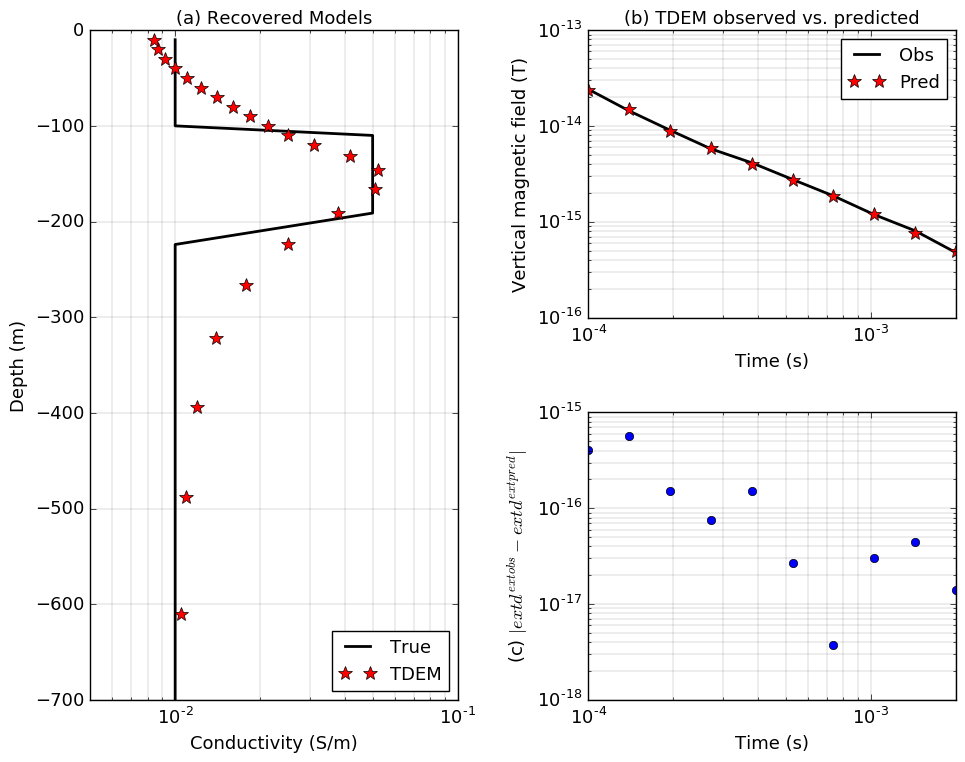

In [59]:
plt.figure(figsize=(10, 8))
ax0 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax2 = plt.subplot2grid((2, 2), (1, 1))

fs = 13  # fontsize
matplotlib.rcParams['font.size'] = fs

# Plot the model
ax0.semilogx(sigma[active], mesh.vectorCCz[active], 'k-', lw=2)
ax0.semilogx(np.exp(moptTD), mesh.vectorCCz[active], 'r*', ms=10)
ax0.set_ylim(-700, 0)
ax0.set_xlim(5e-3, 1e-1)

ax0.set_xlabel('Conductivity (S/m)', fontsize=fs)
ax0.set_ylabel('Depth (m)', fontsize=fs)
ax0.grid(
    which='both', color='k', alpha=0.5, linestyle='-', linewidth=0.2
)
ax0.legend(['True', 'TDEM'], fontsize=fs, loc=4)

# plot the data misfits - negative b/c we choose positive to be in the
# direction of primary
dpred = surveyTD.dpred(moptTD)
ax1.loglog(times, surveyTD.dobs, 'k-', lw=2)
ax1.loglog(times, dpred, 'r*', ms=10)
ax1.set_xlim(times.min(), times.max())

# plot the difference
ax2.loglog(times, np.abs(dpred-surveyTD.dobs), 'bo')
ax2.set_xlim(times.min(), times.max())
ax2.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)
ax2.set_xlabel('Time (s)', fontsize=fs)
ax2.set_ylabel('(c) $|\text{d}^{\text{obs}} - \text{d}^{\text{pred}}|$', fontsize=fs)

# Labels, gridlines, etc
ax1.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)
ax1.set_xlabel('Time (s)', fontsize=fs)
ax1.set_ylabel('Vertical magnetic field (T)', fontsize=fs)
ax1.legend(("Obs", "Pred"), fontsize=fs)

ax0.set_title("(a) Recovered Models", fontsize=fs)
ax1.set_title("(b) TDEM observed vs. predicted", fontsize=fs)

plt.tight_layout(pad=1.5)